# Loading data with polars from postgres database

In [4]:
import polars as pl
import psycopg2

In [7]:
conn = psycopg2.connect(
    dbname="handson",
    user="postgres",
    password="postgres",
    host="localhost",
)

mnist = pl.read_database(
    query="SELECT id, label, pixels from mnist",
    connection=conn,
)

In [8]:
mnist.head()

id,label,pixels
i64,i64,list[f64]
1,0,"[0.0, 0.0, … 0.0]"
2,7,"[0.0, 0.0, … 0.0]"
3,1,"[0.0, 0.0, … 0.0]"
4,1,"[0.0, 0.0, … 0.0]"
5,4,"[0.0, 0.0, … 0.0]"


In [11]:
mnist[0, -1].shape

(784,)

In [20]:
X = mnist.select(pl.col('pixels'))
y = mnist.select(pl.col('label'))

In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [52]:
some_digit = X.item(0, 'pixels')
some_label = y.item(0, 'label')

some_digit_image = some_digit.to_numpy().reshape((28,28))

In [163]:
some_five = mnist.filter(
    pl.col('label') == 5
).item(0, 'pixels')

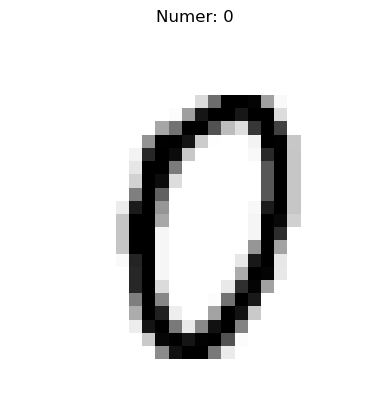

In [58]:
plt.imshow(some_digit_image, cmap= mpl.cm.binary, interpolation="nearest")
plt.axis('off')
plt.title(f"Numer: {some_label}")
plt.show()

In [60]:
y = y.select(pl.col('label').cast(pl.Int8))

In [251]:
X_train = X[:60000, :]
y_train = y[:60000, :]
X_test = X[60000:, :]
y_test = y[60000:, :]

In [80]:
y_train_dig_proportion = y_train.select(
    pl.col('label').value_counts(normalize=True)
).unnest('label').sort('label')
y_test_dig_proportion = y_test.select(
    pl.col('label').value_counts(normalize=True)
).unnest('label').sort('label')

In [72]:
import seaborn as sns

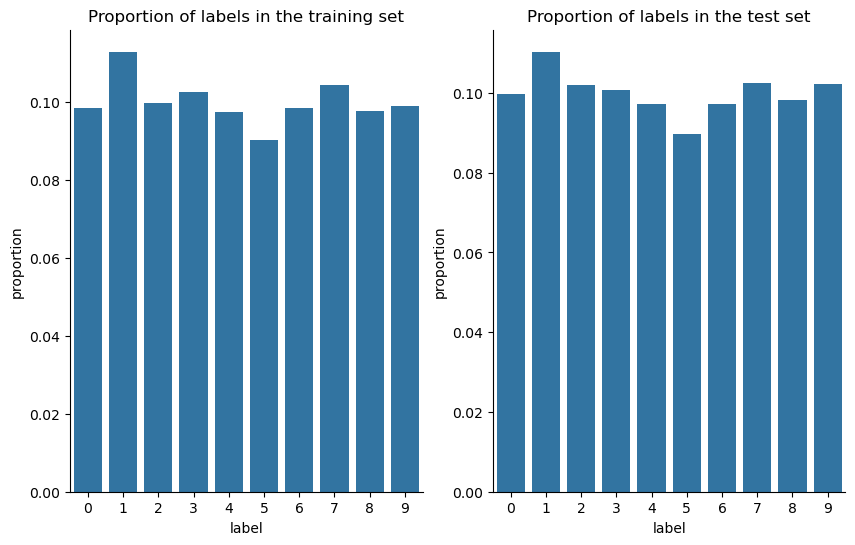

In [90]:
fig, axes = plt.subplots(1,2,figsize=(10, 6))
sns.barplot(x=y_train_dig_proportion['label'], y=y_train_dig_proportion['proportion'], ax=axes[0])
axes[0].set_title('Proportion of labels in the training set')
sns.barplot(x=y_test_dig_proportion['label'], y=y_test_dig_proportion['proportion'], ax=axes[1])
axes[1].set_title('Proportion of labels in the test set')
sns.despine()

## The 5 detector

In [131]:
import numpy as np

In [254]:
y_train_5 = y_train.select(pl.col('label') == 5)
y_test_5 = y_test.select(pl.col('label') == 5)

In [148]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train_array, y_train_5)

/opt/homebrew/Caskroom/miniforge/base/envs/handson/lib/python3.14/site-packages/sklearn/utils/validation.py:1352: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,"loss loss: {'hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'}, default='hinge'The loss function to be used.- 'hinge' gives a linear SVM.- 'log_loss' gives logistic regression, a probabilistic classifier.- 'modified_huber' is another smooth loss that brings tolerance to outliers as well as probability estimates.- 'squared_hinge' is like hinge but is quadratically penalized.- 'perceptron' is the linear loss used by the perceptron algorithm.- The other losses, 'squared_error', 'huber', 'epsilon_insensitive' and 'squared_epsilon_insensitive' are designed for regression but can be useful in classification as well; see :class:`~sklearn.linear_model.SGDRegressor` for a description.More details about the losses formulas can be found in the :ref:`User Guide` and you can find a visualisation of the lossfunctions in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_loss_functions.py`.",'hinge'
,"penalty penalty: {'l2', 'l1', 'elasticnet', None}, default='l2'The penalty (aka regularization term) to be used. Defaults to 'l2'which is the standard regularizer for linear SVM models. 'l1' and'elasticnet' might bring sparsity to the model (feature selection)not achievable with 'l2'. No penalty is added when set to `None`.You can see a visualisation of the penalties in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_penalties.py`.",'l2'
,"alpha alpha: float, default=0.0001Constant that multiplies the regularization term. The higher thevalue, the stronger the regularization. Also used to compute thelearning rate when `learning_rate` is set to 'optimal'.Values must be in the range `[0.0, inf)`.",0.0001
,"l1_ratio l1_ratio: float, default=0.15The Elastic Net mixing parameter, with 0 <= l1_ratio <= 1.l1_ratio=0 corresponds to L2 penalty, l1_ratio=1 to L1.Only used if `penalty` is 'elasticnet'.Values must be in the range `[0.0, 1.0]` or can be `None` if`penalty` is not `elasticnet`... versionchanged:: 1.7 `l1_ratio` can be `None` when `penalty` is not ""elasticnet"".",0.15
,"fit_intercept fit_intercept: bool, default=TrueWhether the intercept should be estimated or not. If False, thedata is assumed to be already centered.",True
,"max_iter max_iter: int, default=1000The maximum number of passes over the training data (aka epochs).It only impacts the behavior in the ``fit`` method, and not the:meth:`partial_fit` method.Values must be in the range `[1, inf)`... versionadded:: 0.19",1000
,"tol tol: float or None, default=1e-3The stopping criterion. If it is not None, training will stopwhen (loss > best_loss - tol) for ``n_iter_no_change`` consecutiveepochs.Convergence is checked against the training loss or thevalidation loss depending on the `early_stopping` parameter.Values must be in the range `[0.0, inf)`... versionadded:: 0.19",0.001
,"shuffle shuffle: bool, default=TrueWhether or not the training data should be shuffled after each epoch.",True
,"verbose verbose: int, default=0The verbosity level.Values must be in the range `[0, inf)`.",0
,"epsilon epsilon: float, default=0.1Epsilon in the epsilon-insensitive loss functions; only if `loss` is'huber', 'epsilon_insensitive', or 'squared_epsilon_insensitive'.For 'huber', determines the threshold at which it becomes lessimportant to get the prediction exactly right.For epsilon-insensitive, any differences between the current predictionand the correct label are ignored if they are less than this threshold.Values must be in the range `[0.0, inf)`.",0.1
,"n_jobs n_jobs: int, default=NoneThe number of CPUs to use to do the OVA (One Versus All, formulti-class problems) computation.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None


### Manual CV

In [257]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

X_train_numpy = np.array(X_train['pixels'].to_list())
y_train_5_numpy = np.array(y_train_5['label'].to_list()).ravel()

# assuming we're dealing with Polars Dataframes
for i, (train_index, test_index) in enumerate(skfolds.split(X_train_numpy, y_train_5_numpy), 1):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train_numpy[train_index]
    y_train_5_folds = y_train_5_numpy[train_index]
    X_test_folds = X_train_numpy[test_index]
    y_test_5_folds = y_train_5_numpy[test_index]

    clone_clf.fit(X_train_folds, y_train_5_folds)
    y_pred = clone_clf.predict(X_test_folds)
    accuracy = np.mean(y_test_5_folds == y_pred)
    print(f"Accuracy of fold {i}: {accuracy:.4f}")

Accuracy of fold 1: 0.9686
Accuracy of fold 2: 0.9315
Accuracy of fold 3: 0.9610


### CV built-in

In [258]:
from sklearn.model_selection import cross_val_score

sgd_cv_score = cross_val_score(sgd_clf, X_train_numpy, y_train_5_numpy, cv=3, scoring='accuracy')
print(sgd_cv_score)

[0.9686 0.9315 0.961 ]


### Dumb Classfier

In [259]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass

    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [262]:
dumb_clf = Never5Classifier()
y_pred_5_dumb = dumb_clf.predict(X_train_numpy)
cv_dumb = cross_val_score(dumb_clf, X_train_numpy, y_train_5_numpy, cv=3, scoring='accuracy')
print(cv_dumb)

[0.91205 0.90815 0.90915]


### Confussion Matrix

In [263]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

cv_y_train_pred = cross_val_predict(sgd_clf, X_train_numpy, y_train_5_numpy, n_jobs=-1, cv=3)
sgd_confussion_matrix = confusion_matrix(y_train_5_numpy, cv_y_train_pred)

In [269]:
perfect_confussion_matrix = confusion_matrix(y_train_5_numpy, y_train_5_numpy)

In [304]:
dumb_confussion_matrix = confusion_matrix(y_train_5_numpy, y_pred_5_dumb)

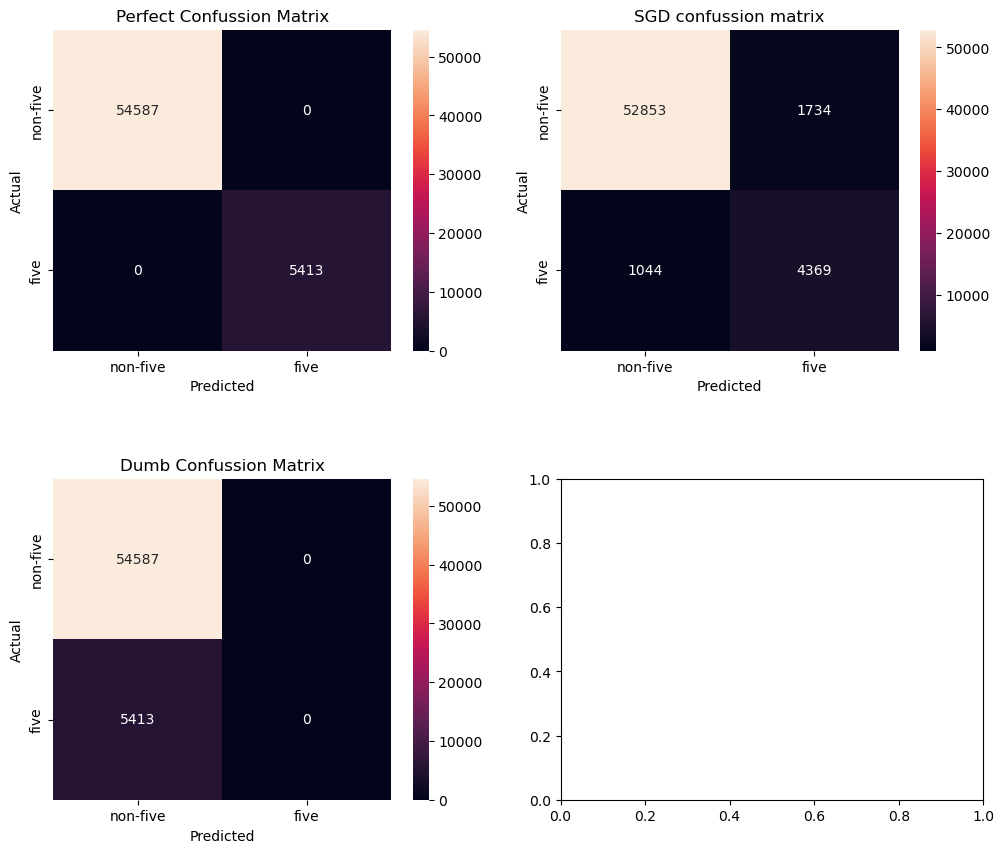

In [308]:
fig, axes  = plt.subplots(2,2, figsize=(12,10))
labels = ['non-five', 'five']
plt.subplots_adjust(hspace=0.4)
plt.subplot(2,2,1)
plt.title('Perfect Confussion Matrix')
sns.heatmap(perfect_confussion_matrix, annot=True, fmt='.0f', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.subplot(2,2,2)
plt.title('SGD confussion matrix')
sns.heatmap(sgd_confussion_matrix, annot=True, fmt='.0f', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.subplot(2,2,3)
plt.title('Dumb Confussion Matrix')
sns.heatmap(dumb_confussion_matrix, annot=True, fmt='.0f', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [310]:
from sklearn.metrics import precision_score, recall_score, f1_score

sgd_precision = precision_score(y_train_5_numpy, cv_y_train_pred)
sgd_recall = recall_score(y_train_5_numpy, cv_y_train_pred)
sgd_f1_score = f1_score(y_train_5_numpy, cv_y_train_pred)
print('SGD performance')
print(f"F1-score: {sgd_f1_score:.2f}")
print(f'Precision: {sgd_precision:.2f}')
print(f'Recall: {sgd_recall:.2f}')

SGD performance
F1-score: 0.76
Precision: 0.72
Recall: 0.81


In [311]:
y_scores = cross_val_predict(sgd_clf, X_train_numpy, y_train_5_numpy, cv=3, method='decision_function')
print(y_scores)

[ -1950.67392536  -8701.90632311  -6420.93233005 ... -14320.65987308
 -27535.21653823 -10383.91380572]


In [312]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5_numpy, y_scores)

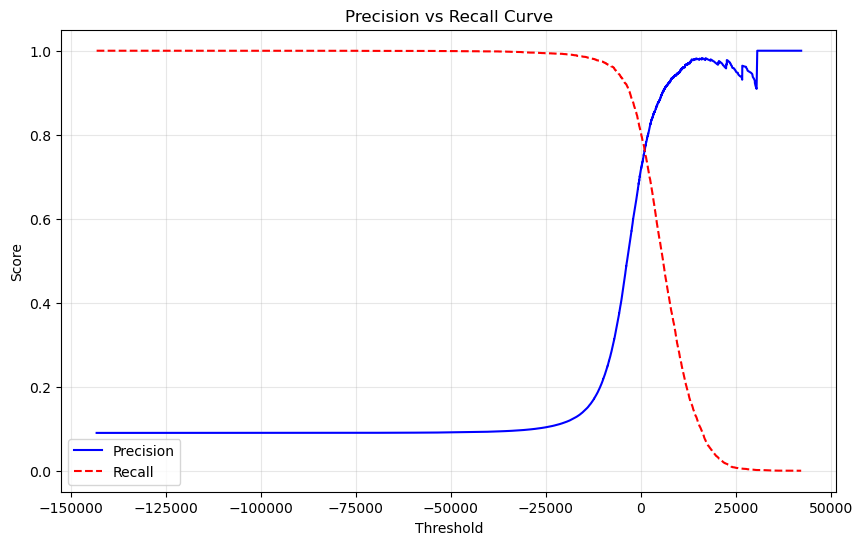

In [325]:
plt.figure(figsize=(10, 6))
plt.title('Precision vs Recall Curve')
plt.plot(thresholds, precisions[:-1], 'b-', label='Precision')
plt.plot(thresholds, recalls[:-1], 'r--', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

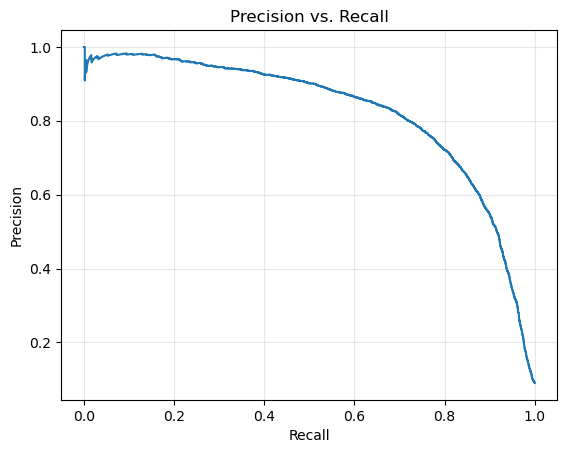

In [334]:
plt.title('Precision vs. Recall')
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True, alpha=0.3)

plt.show()

In [335]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [337]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [340]:
precision_90 = precision_score(y_train_5_numpy, y_train_pred_90)
recall_90 = recall_score(y_train_5_numpy, y_train_pred_90)
print(f'Precision: {precision_90}')
print(f'Recall: {recall_90}')

Precision: 0.9
Recall: 0.510437834842047


## The roc curve

In [343]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5_numpy, y_scores)

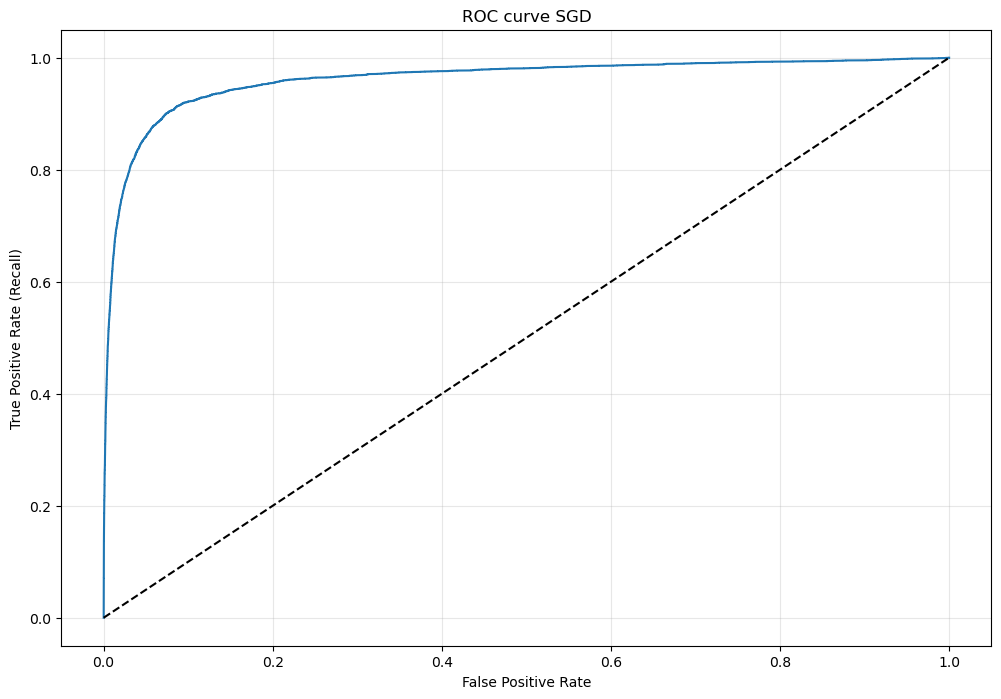

In [357]:
plt.figure(figsize=(12,8))
plt.title('ROC curve SGD')
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], 'k--')
plt.grid(True, alpha=.3)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.show()

In [350]:
from sklearn.metrics import roc_auc_score #receiving operator characteristic
roc_auc_score(y_train_5_numpy, y_scores)


0.9616844192447358

## Using a different model

In [353]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train_numpy, y_train_5_numpy, 
                                    cv=3, method='predict_proba', n_jobs=-1)

In [358]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds = roc_curve(y_train_5_numpy, y_scores_forest)

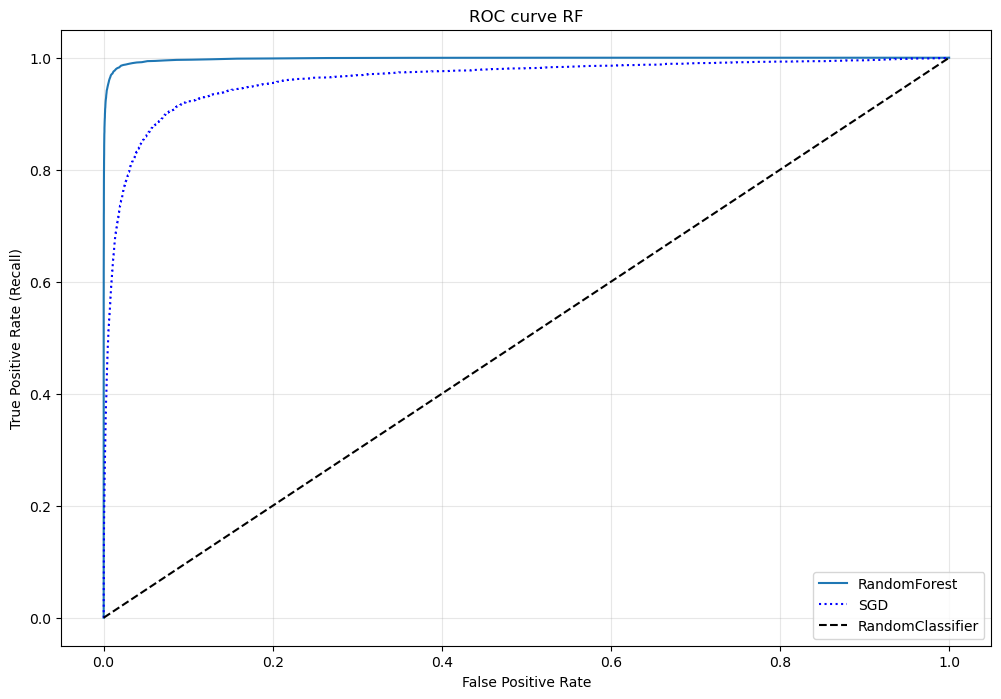

In [363]:
plt.figure(figsize=(12,8))
plt.title('ROC curve RF')
plt.plot(fpr_forest, tpr_forest, label='RandomForest')
plt.plot(fpr, tpr, "b:", label='SGD')
plt.plot([0,1], [0,1], 'k--', label='RandomClassifier')
plt.grid(True, alpha=.3)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.legend(loc='lower right')
plt.show()

In [364]:
roc_auc_score(y_train_5_numpy, y_scores_forest)

0.9982481301718765

In [379]:
rf_predict = np.argmax(y_probas_forest, axis=1).astype(bool)

In [384]:
rf_precision = precision_score(y_train_5_numpy, rf_predict)
rf_recall = recall_score(y_train_5_numpy, rf_predict)
print(f'Precision: {rf_precision:.3f}')
print(f'Recall: {rf_recall:.3f}')

Precision: 0.989
Recall: 0.868


## Multiclass

In [390]:
y_train_array = np.array(y_train['label'].to_list())
X_train_array = X_train_numpy

In [391]:
sgd_clf.fit(X_train_array, y_train_array)

,"loss loss: {'hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'}, default='hinge'The loss function to be used.- 'hinge' gives a linear SVM.- 'log_loss' gives logistic regression, a probabilistic classifier.- 'modified_huber' is another smooth loss that brings tolerance to outliers as well as probability estimates.- 'squared_hinge' is like hinge but is quadratically penalized.- 'perceptron' is the linear loss used by the perceptron algorithm.- The other losses, 'squared_error', 'huber', 'epsilon_insensitive' and 'squared_epsilon_insensitive' are designed for regression but can be useful in classification as well; see :class:`~sklearn.linear_model.SGDRegressor` for a description.More details about the losses formulas can be found in the :ref:`User Guide` and you can find a visualisation of the lossfunctions in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_loss_functions.py`.",'hinge'
,"penalty penalty: {'l2', 'l1', 'elasticnet', None}, default='l2'The penalty (aka regularization term) to be used. Defaults to 'l2'which is the standard regularizer for linear SVM models. 'l1' and'elasticnet' might bring sparsity to the model (feature selection)not achievable with 'l2'. No penalty is added when set to `None`.You can see a visualisation of the penalties in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_penalties.py`.",'l2'
,"alpha alpha: float, default=0.0001Constant that multiplies the regularization term. The higher thevalue, the stronger the regularization. Also used to compute thelearning rate when `learning_rate` is set to 'optimal'.Values must be in the range `[0.0, inf)`.",0.0001
,"l1_ratio l1_ratio: float, default=0.15The Elastic Net mixing parameter, with 0 <= l1_ratio <= 1.l1_ratio=0 corresponds to L2 penalty, l1_ratio=1 to L1.Only used if `penalty` is 'elasticnet'.Values must be in the range `[0.0, 1.0]` or can be `None` if`penalty` is not `elasticnet`... versionchanged:: 1.7 `l1_ratio` can be `None` when `penalty` is not ""elasticnet"".",0.15
,"fit_intercept fit_intercept: bool, default=TrueWhether the intercept should be estimated or not. If False, thedata is assumed to be already centered.",True
,"max_iter max_iter: int, default=1000The maximum number of passes over the training data (aka epochs).It only impacts the behavior in the ``fit`` method, and not the:meth:`partial_fit` method.Values must be in the range `[1, inf)`... versionadded:: 0.19",1000
,"tol tol: float or None, default=1e-3The stopping criterion. If it is not None, training will stopwhen (loss > best_loss - tol) for ``n_iter_no_change`` consecutiveepochs.Convergence is checked against the training loss or thevalidation loss depending on the `early_stopping` parameter.Values must be in the range `[0.0, inf)`... versionadded:: 0.19",0.001
,"shuffle shuffle: bool, default=TrueWhether or not the training data should be shuffled after each epoch.",True
,"verbose verbose: int, default=0The verbosity level.Values must be in the range `[0, inf)`.",0
,"epsilon epsilon: float, default=0.1Epsilon in the epsilon-insensitive loss functions; only if `loss` is'huber', 'epsilon_insensitive', or 'squared_epsilon_insensitive'.For 'huber', determines the threshold at which it becomes lessimportant to get the prediction exactly right.For epsilon-insensitive, any differences between the current predictionand the correct label are ignored if they are less than this threshold.Values must be in the range `[0.0, inf)`.",0.1
,"n_jobs n_jobs: int, default=NoneThe number of CPUs to use to do the OVA (One Versus All, formulti-class problems) computation.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None


In [392]:
sgd_clf.predict([some_digit])

array([0])

In [393]:
some_digit_scores = sgd_clf.decision_function([some_digit])

In [394]:
some_digit_scores

array([[  4596.42249367, -27243.26653026, -10863.46506377,
         -9689.10177231,  -5760.60335692,  -6670.95636272,
        -14999.12845015, -25057.28338151,  -1454.79078802,
         -7413.49878619]])

In [395]:
np.argmax(some_digit_scores)

np.int64(0)

In [397]:
sgd_clf.classes_[np.argmax(some_digit_scores)]

np.int64(0)

In [398]:
forest_clf.fit(X_train_array, y_train_array)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [399]:
forest_clf.predict([some_digit])

array([0])

In [400]:
forest_clf.predict_proba([some_digit])

array([[0.97, 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.01, 0.  , 0.  ]])

In [402]:
cross_val_score(sgd_clf, X_train_array, y_train_array, cv=3, n_jobs=-1, scoring="accuracy")

array([0.8807, 0.8696, 0.8721])

In [405]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_array_scaled = scaler.fit_transform(X_train_array)
cross_val_score(sgd_clf, X_train_array_scaled, y_train_array, cv=3, n_jobs=-1, scoring='accuracy')

/opt/homebrew/Caskroom/miniforge/base/envs/handson/lib/python3.14/site-packages/sklearn/linear_model/_stochastic_gradient.py:733: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/handson/lib/python3.14/site-packages/sklearn/linear_model/_stochastic_gradient.py:733: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/handson/lib/python3.14/site-packages/sklearn/linear_model/_stochastic_gradient.py:733: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([0.9032, 0.8894, 0.8962])

In [408]:
y_train_pred = cross_val_predict(sgd_clf, X_train_array_scaled, y_train_array, cv=3, n_jobs=-1)
conf_mx = confusion_matrix(y_train_array, y_train_pred)
conf_mx

/opt/homebrew/Caskroom/miniforge/base/envs/handson/lib/python3.14/site-packages/sklearn/linear_model/_stochastic_gradient.py:733: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/handson/lib/python3.14/site-packages/sklearn/linear_model/_stochastic_gradient.py:733: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/handson/lib/python3.14/site-packages/sklearn/linear_model/_stochastic_gradient.py:733: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([[5552,    0,   22,    7,    9,   46,   39,    6,  227,    1],
       [   1, 6432,   41,   20,    4,   44,    4,    6,  205,   11],
       [  25,   27, 5263,   87,   69,   25,   69,   40,  360,    8],
       [  22,   16,  119, 5214,    2,  203,   30,   39,  422,   74],
       [  11,   13,   45,    9, 5171,   11,   33,   25,  360,  166],
       [  29,   17,   31,  154,   52, 4437,   74,   18,  544,   57],
       [  27,   15,   46,    2,   46,   95, 5535,    3,  137,    0],
       [  21,   12,   53,   24,   48,   16,    3, 5691,  189,  197],
       [  17,   64,   50,   90,    4,  138,   25,    9, 5412,   45],
       [  24,   19,   30,   57,  115,   32,    1,  188,  403, 5069]])

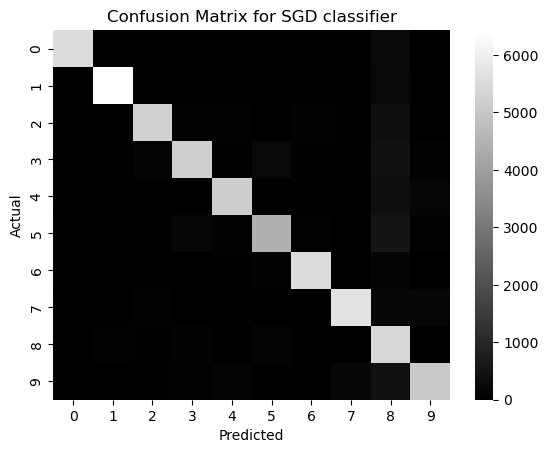

In [418]:
plt.title('Confusion Matrix for SGD classifier')
sns.heatmap(conf_mx, fmt='.0f', cmap='gray')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [435]:
y_train.select(
    pl.col('label').value_counts()
).unnest('label').sort(by='label')

label,count
i8,u32
0,5909
1,6768
2,5973
3,6141
4,5844
5,5413
6,5906
7,6254
8,5854


In [436]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

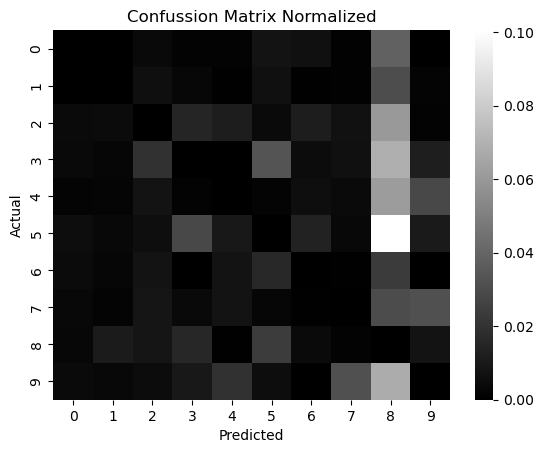

In [441]:
plt.title('Confussion Matrix Normalized - error focused')
np.fill_diagonal(norm_conf_mx, 0)
sns.heatmap(norm_conf_mx, cmap='gray')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [459]:
cl_a, cl_b = 3, 5
# y_train_pred is already a numpy array
X_aa = X_train_array[(y_train_array == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train_array[(y_train_array == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train_array[(y_train_array == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train_array[(y_train_array == cl_b) & (y_train_pred == cl_b)]

In [505]:
def plot_digits(digits, images_per_row, ax=None):
    if ax is None:  fig, ax = plt.subplots(images_per_row, images_per_row)
    digits_to_plot = digits[:images_per_row**2]
    for (el, digit) in enumerate(digits_to_plot, 1):
        plt.subplot(images_per_row, images_per_row, el)
        plt.imshow(digit.reshape(28,28), cmap=mpl.cm.binary)
        plt.axis('off')  


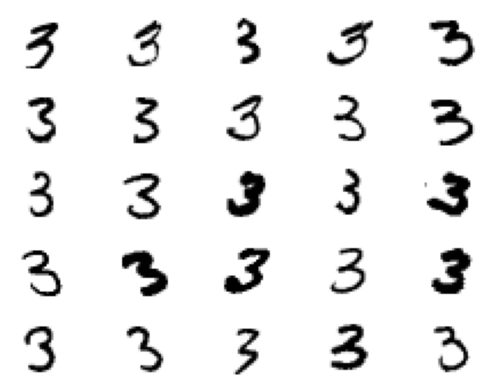

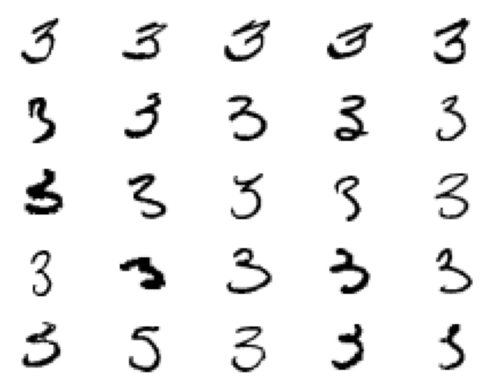

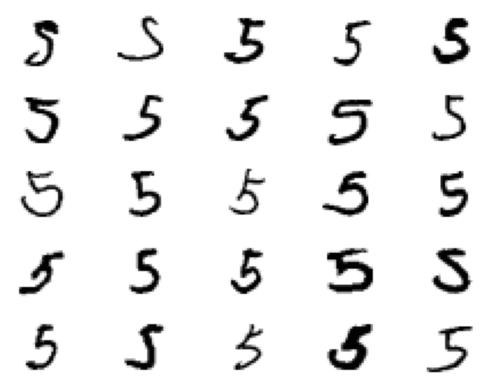

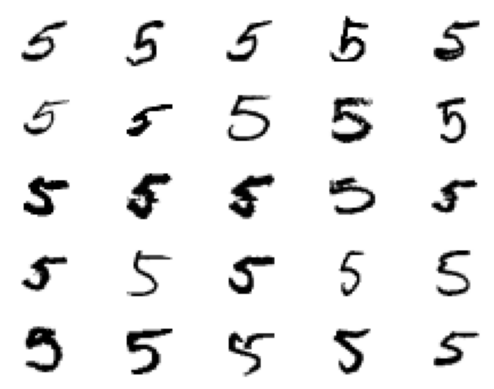

In [507]:
plot_digits(X_aa, 5)
plot_digits(X_ab, 5)
plot_digits(X_ba, 5)
plot_digits(X_bb, 5)


## Multilabel classification

In [515]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train_array >= 7)
y_train_odd = (y_train_array % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [517]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_array, y_multilabel)

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",5
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


In [ ]:
knn_clf.predict([some_digit]) #some digit is 0

array([[False, False]])

In [526]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train_array, y_multilabel, cv=3, n_jobs=-1)

In [527]:
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.9762528584775527

## Multiouput classification

In [528]:
noise = np.random.randint(0, 100, (len(X_train_array), 784))

In [529]:
X_train_mod = X_train_array + noise

In [534]:
X_test_array = np.array(X_test['pixels'].to_list())

In [535]:
noise = np.random.randint(0, 100, X_test_array.shape)

In [536]:
X_test_mod = X_test_array + noise

In [539]:
y_train_mod = X_train_array
y_test_mod = X_test_array

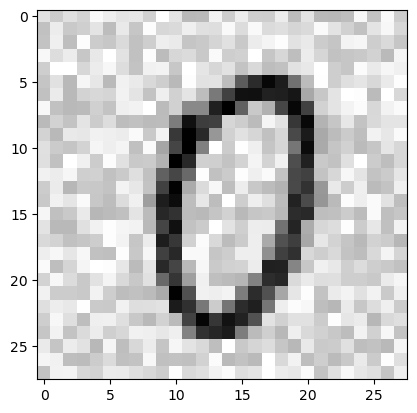

In [552]:
plt.imshow(X_train_mod[0,:].reshape(28,28), cmap='binary')


In [553]:
knn_clf.fit(X_train_mod, y_train_mod)

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",5
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


In [ ]:
clean_digit = knn_clf.predict([some_digit])

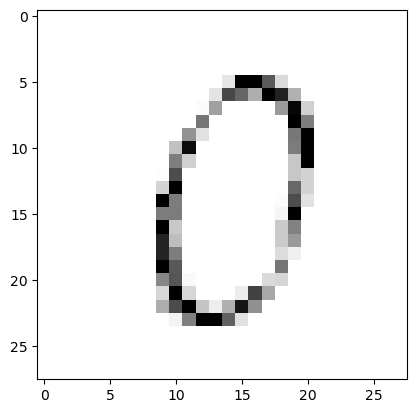

In [556]:
plt.imshow(clean_digit.reshape(28,28), cmap='binary')